# DATR-406 Final Project
## Modeling

### Table of Contents
1. Data Prep
2. Create Holdout Sample
3. Build Baseline Model
4. Train Models
    * Lasso
    * Random Forest
    * Gradient Boosted Tree
5. Cross Validation
6. Compare Models
7. Understanding Variable Relationships
    * Low Target Values
    * Feature Importances
8. Feature Tuning
9. Save Final Versions
10. Evaluate on Holdout Set

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import re
import pickle

from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# update default matplotlib settings for font
plt.rc('font', size=14)
plt.rc('axes', labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('figure', titlesize=16)

In [3]:
# set random state/seed for reproducability
random_seed = 4

### Step 1: Data Prep <a name="step1"></a>

In [4]:
data = pd.read_csv('data/combined_data.csv')

urban_dummies = pd.get_dummies(data['urbanity'], prefix='urbanity')
data = pd.concat([data, urban_dummies], axis=1)

print(data.columns)
print('raw data shape: ', data.shape)

# Note: I am intentionally keeping all of the dummy variables here and since all of the models used below can handle multi-collinearity/feature selection.

Index(['geoid', 'rate_2010', 'state', 'urbanity', 'name', 'total_pop',
       'total_hholds', 'speak_only_english', 'educ_less_than_hs',
       'educ_hs_grad', 'educ_some_college', 'educ_college_grad',
       'educ_post_grad', 'income_u10k', 'income_10k_to_u15k',
       'income_15k_to_u25k', 'income_25k_to_u35k', 'income_35k_to_u50k',
       'income_50k_to_u65k', 'income_65k_to_u75k', 'income_75k_or_more',
       'marital_never_married', 'livinginarea_1_to_4', 'livinginarea_5_to_17',
       'livinginarea_18_to_19', 'livinginarea_20_to_49',
       'livinginarea_50_plus', 'citizenship_non_citizen',
       'incomepovertyratio_u1', 'incomepovertyratio_1_to_2',
       'incomepovertyratio_2_plus', 'hh_with_earnings', 'employ_employed',
       'employ_unemployed', 'inequality_index_gini', 'hhtype_married_couple',
       'hhtype_m_householder', 'hhtype_f_householder', 'hhtype_living_alone',
       'traveltowork_drove_alone', 'traveltowork_carpooled',
       'traveltowork_public_transit', 'comm

### Step 2: Create Holdout Sample <a name="step2"></a>

In [5]:
# create holdout sample of 15%, saving the rest back to the "data" dataframe
holdout = data.sample(frac=0.15, random_state=random_seed)
holdout.to_pickle('data/objects/holdout.pkl')

data = data.merge(holdout, how='left', indicator=True)
data = data.loc[data['_merge'] == 'left_only', :].copy()
data.drop('_merge', axis='columns', inplace=True)
print('holdout set shape:', holdout.shape)
print('remaining data shape:', data.shape)

holdout set shape: (466, 57)
remaining data shape: (2642, 57)


----- data or holdout is null


state  data_pct  holdout_pct
48    HI  0.001514          NaN
49    DE  0.001136          NaN
50    DC  0.000379          NaN


----- stats on differences in state percentages


count    48.000000
mean      0.005905
std       0.005525
min       0.000019
25%       0.001884
50%       0.004298
75%       0.008686
max       0.021795
Name: diff, dtype: float64

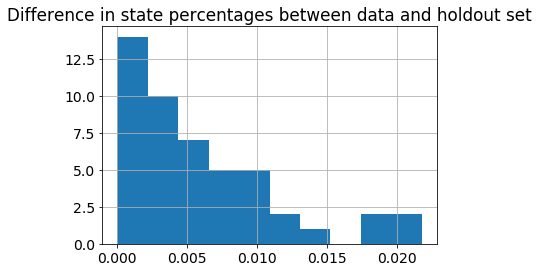

In [6]:
# check that the holdout sample is representative by state
holdout_counts = holdout['state'].value_counts(normalize=True).to_frame().reset_index()
holdout_counts.columns = ['state', 'holdout_pct']
data_counts = data['state'].value_counts(normalize=True).to_frame().reset_index()
data_counts.columns = ['state', 'data_pct']

state_counts = pd.merge(data_counts, holdout_counts, how='outer')
mask = (state_counts['holdout_pct'].isnull()) | (state_counts['data_pct'].isnull())

# calculate differences in percent between holdout set and rest of data, then describe/graph those differences
state_counts['diff'] = abs(state_counts['holdout_pct'] - state_counts['data_pct'])

print('----- data or holdout is null')
display(state_counts.loc[mask, ['state', 'data_pct', 'holdout_pct']])
print('\n----- stats on differences in state percentages')
display(state_counts['diff'].describe())
state_counts['diff'].hist()
plt.title('Difference in state percentages between data and holdout set');

The max difference is 2 percent with most differences clustered around zero.  So the holdout set is representative by state.

### Step 3: Build Baseline Model

In [7]:
# split the data for train and test
y = data['rate_2010']
X = data.drop('rate_2010', axis='columns')
non_features = ['geoid', 'state', 'urbanity', 'name']
X.drop(non_features, axis='columns', inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_seed)

In [8]:
# create objects to compare models on train and test data, plus metrics
all_models = {}
y_comp_train = pd.DataFrame()
y_comp_train['true'] = y_train
y_comp_test = pd.DataFrame()
y_comp_test['true'] = y_test

In [9]:
# build and evaluate the baseline model on train and test
y_null = np.zeros_like(y_train, dtype=float)
y_null.fill(y_train.mean())
y_null_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_null))

y_null_test = np.zeros_like(y_test, dtype=float)
y_null_test.fill(y_train.mean())
y_null_rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_null_test))

train_r2 = np.sqrt(metrics.r2_score(y_train, y_null))
test_r2 = np.sqrt(metrics.r2_score(y_test, y_null_test))

print('baseline rmse is train {}, test {}'.format(round(y_null_rmse, 4), round(y_null_rmse_test, 4)))
print('r2 is train {}, test {}'.format(round(train_r2, 4), round(test_r2, 4)))

all_models['baseline'] = {'train_rmse': y_null_rmse, 'test_rmse': y_null_rmse_test,
                          'train_r2': train_r2, 'test_r2': test_r2}
y_comp_train['baseline'] = y_null
y_comp_test['baseline'] = y_null_test

baseline rmse is train 0.1119, test 0.1129
r2 is train 0.0, test nan


In [10]:
# create a function to format time delta outputs, used for timing
def format_delta(start, end):
    ''' format time delta of end - start

    :param start: start datetime
    :param end: end datetime

    :return: string
    '''

    diff = end - start
    formatted_time = ':'.join(str(diff).split(':')[1:3])
    formatted_time = formatted_time.split('.')[0]
    return formatted_time


In [11]:
# create a function to transform, fit, predict, evaluate a model and add it to the collections above
def eval_model(model_name, model_object, transformer=None):
    ''' Fit and evaluate a model

    This uses variables defined outside the function:
        X_train = training dataframe
        X_test = test dataframe
        y_train = training output series
        y_test = test output series
        all_models = dict of model components
        y_comp_train = y_hat dataframe
        y_comp_test = y_hat dataframe
    
    This function applies the following steps:
        Fit and apply the given transformer to X_train, X_test (if specified)
        Fit the model object using the transformed X_train, y_train
        Build yhat using fitted model's predict method on the transformed X_train and X_test
        Calculate the train and test rmse and print it out
        Calculate the train and test r2 and print it out
        Add the model components to the all_models dict; add yhat to the y_comp dataframe
    
    :param model_name: str name
    :param model_object: sklearn object to fit
    :param transformer: transformer to fit on x_train/x_test

    :return: None
    '''

    start = dt.datetime.now()
    
    if transformer is not None:
        temp_x_train = transformer.fit_transform(X_train)
        temp_x_test = transformer.transform(X_test)
    else:
        temp_x_train = X_train
        temp_x_test = X_test

    model_object.fit(temp_x_train, y_train)
    yhat_train = model_object.predict(temp_x_train)
    yhat_test = model_object.predict(temp_x_test)

    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, yhat_train))
    test_rmse = np.sqrt(metrics.mean_squared_error(y_test, yhat_test))

    train_r2 = np.sqrt(metrics.r2_score(y_train, yhat_train))
    test_r2 = np.sqrt(metrics.r2_score(y_test, yhat_test))

    print('{} rmse is train {}, test {}'.format(model_name, round(train_rmse, 4), round(test_rmse, 4)))
    print('r2 is train {}, test {}'.format(round(train_r2, 4), round(test_r2, 4)))

    all_models[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse, 
                              'train_r2': train_r2, 'test_r2': test_r2, 
                              'model': model_object, 'transformer': transformer}
    y_comp_train[model_name] = yhat_train
    y_comp_test[model_name] = yhat_test

    end = dt.datetime.now()
    formatted_time = format_delta(start, end)
    print('fit and evaluated in {}'.format(formatted_time))


### Step 4: Train Models

In [12]:
# instantiate transformer for building interactions
poly = PolynomialFeatures(2, interaction_only=True)

#### Step 4A: Lasso

In [13]:
eval_model('lasso', Lasso(random_state=random_seed), transformer=poly)

lasso rmse is train 0.0846, test 0.0884
r2 is train 0.654, test 0.6218
fit and evaluated in 00:01


#### Step 4B: Random Forest

In [14]:
regr = RandomForestRegressor(random_state=random_seed)
eval_model('random_forest', regr, transformer=poly)

random_forest rmse is train 0.0297, test 0.0843
r2 is train 0.964, test 0.6647
fit and evaluated in 01:28


#### Step 4C: Gradient Boosted Tree

In [15]:
gbt = GradientBoostingRegressor(random_state=random_seed)
eval_model('gradient_boost', gbt, transformer=poly)

gradient_boost rmse is train 0.0477, test 0.0822
r2 is train 0.9047, test 0.6854
fit and evaluated in 00:45


### Step 5: Cross Validation

In [16]:
# run cross validation on model objects created above, applying transformers to X and adding resulting cv_rmse to dict
# NOTE: this takes about 13 minutes to run (on my machine)
total_start = dt.datetime.now()
temp_all_models = all_models.copy()

for k, m in temp_all_models.items():
    start = dt.datetime.now()
    m_new = m.copy()
    if k == 'baseline':
        m_new['cv_rmse'] = m_new['test_rmse']
    else:
        if m_new['transformer'] is None:
            temp_x = X
        else:
            temp_x = m['transformer'].fit_transform(X)
        cv_results = cross_validate(m['model'], temp_x, y, cv=5, scoring=['neg_mean_squared_error', 'r2'])
        cv_rmse = np.sqrt(np.mean(-1 * cv_results['test_neg_mean_squared_error']))
        m_new['cv_rmse'] = cv_rmse
        cv_r2 = np.mean(cv_results['test_r2'])
        m_new['cv_r2'] = cv_r2
    all_models[k] = m_new

    end = dt.datetime.now()
    formatted_time = format_delta(start, end)
    print('{} cross-validated in {}'.format(k, formatted_time))

total_end = dt.datetime.now()
formatted_time = format_delta(total_start, total_end)
print('all cross-validation completed in {}'.format(formatted_time))

baseline cross-validated in 00:00
lasso cross-validated in 00:06
random_forest cross-validated in 08:25
gradient_boost cross-validated in 04:13
all cross-validation completed in 12:44


### Step 6: Compare Models

In [17]:
# build a dataframe from the all_models dict to compare train, test and cross validation statistics
model_comp = pd.DataFrame(all_models).transpose().reset_index()
model_comp.rename({'index': 'model_name'}, axis='columns', inplace=True)
model_comp.drop(['model', 'transformer'], axis='columns', inplace=True)

display(model_comp)

model_name train_rmse  test_rmse  train_r2   test_r2    cv_rmse  \
0        baseline   0.111876   0.112931         0       NaN   0.112931   
1           lasso  0.0846324  0.0884045  0.654014  0.621839  0.0909034   
2   random_forest  0.0297302  0.0843409  0.964044  0.664659  0.0869883   
3  gradient_boost  0.0476564  0.0822015  0.904735   0.68537  0.0861201   

      cv_r2  
0       NaN  
1  0.271647  
2   0.33529  
3   0.34992

In [18]:
# list out stats for the true and predicted target variables for the train and test sets
print('training data')
display(y_comp_train.describe().transpose())

print('\ntest data')
display(y_comp_test.describe().transpose())

training data


count      mean           std       min       25%       50%  \
true            1981.0  0.703619  1.119044e-01  0.000000  0.640000  0.740000   
baseline        1981.0  0.703619  2.631893e-14  0.703619  0.703619  0.703619   
lasso           1981.0  0.703619  6.284929e-02  0.397972  0.660267  0.711010   
random_forest   1981.0  0.703621  9.135785e-02  0.286800  0.649100  0.727100   
gradient_boost  1981.0  0.703619  8.850112e-02  0.160867  0.655202  0.725470   

                     75%       max  
true            0.780000  0.900000  
baseline        0.703619  0.703619  
lasso           0.749028  0.910701  
random_forest   0.772800  0.868200  
gradient_boost  0.769129  0.829106


test data


count      mean           std       min       25%       50%  \
true            661.0  0.706884  1.129694e-01  0.180000  0.650000  0.740000   
baseline        661.0  0.703619  3.333191e-15  0.703619  0.703619  0.703619   
lasso           661.0  0.703525  6.422148e-02  0.433141  0.663385  0.712298   
random_forest   661.0  0.703938  7.060520e-02  0.427900  0.652700  0.713700   
gradient_boost  661.0  0.705597  7.723096e-02  0.430363  0.656308  0.723873   

                     75%       max  
true            0.790000  0.870000  
baseline        0.703619  0.703619  
lasso           0.750537  0.886006  
random_forest   0.758900  0.838200  
gradient_boost  0.766120  0.826122

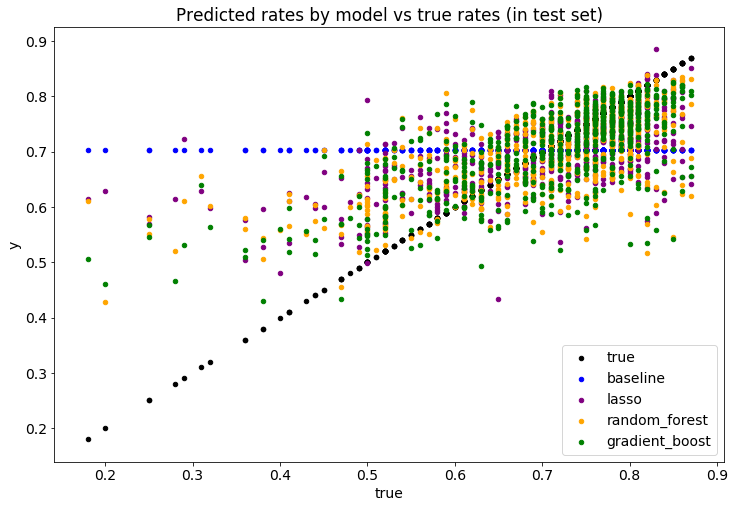

In [19]:
# plot the predicted targets for each model against the actual y in the test set
fig, ax = plt.subplots(figsize=(12,8))
colors = ['black', 'b', 'purple', 'orange', 'g']
models = list(y_comp_test.columns)
for i, col in enumerate(models):
    y_comp_test.plot(kind='scatter', x='true', y=models[i], color=colors[i], ax=ax, label=models[i])
ax.set_ylabel('y')
ax.set_title('Predicted rates by model vs true rates (in test set)')
leg = ax.legend();
plt.savefig('data/imgs/test_model_comp.png')

The gradient boosted tree and random forest models perform best on the test set and in cross validation.  The gradient boost is much more efficient to train so I will focus on that going forward.

None of the models predict values below about 0.4 even though there are true values at that level.  In the next section I will explore how common these low values are in the training data and look at how to improve the model accordingly.

### Step 7: Understanding Variable Relationships

#### Step 7A: Low target values

In [20]:
# create a function to label interaction terms created by polynomial transformer
def interaction_columns(cols):
    ''' build interaction column names based on polynomial transformer

    :param cols: list of input columns
    
    :return: list of new names
    '''

    new_cols = []
    for i, c in enumerate(cols):
        for j in range(i+1, len(cols)):
            new_cols.append('{}__{}'.format(c, cols[j]))
    all_cols = ['1'] + cols + new_cols
    return all_cols


coverage of low rates in training data


normal        0.99037
low (<0.4)    0.00963
Name: low_rate, dtype: float64

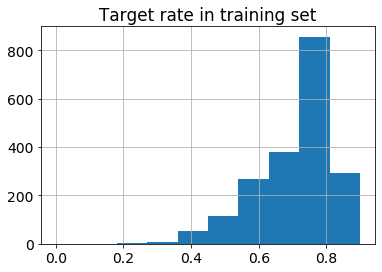

In [21]:
# apply the polynomial transformer to the training data and add the true/predicted target variables
X_train_interact = poly.fit_transform(X_train)
new_cols = interaction_columns(list(X_train.columns))
X_train_interact = pd.DataFrame(X_train_interact, columns=new_cols)

comb_train = pd.concat([X_train_interact, y_comp_train], axis=1)

# create a dummy variable for target rates below 0.4
comb_train['low_rate'] = 'normal'
comb_train.loc[comb_train['true'] < 0.4, 'low_rate'] = 'low (<0.4)'

print('coverage of low rates in training data')
display(comb_train['low_rate'].value_counts(normalize=True))

comb_train['true'].hist()
plt.title('Target rate in training set');

coverage of low rates in test data


normal        0.989787
low (<0.4)    0.010213
Name: low_rate, dtype: float64

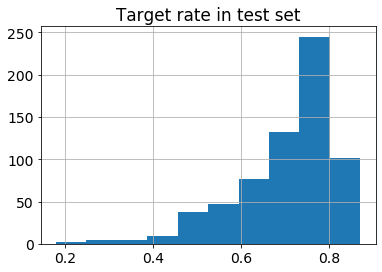

In [22]:
# do the same for the test set
# apply the polynomial transformer to the test data and add the true/predicted target variables
X_test_interact = poly.transform(X_test)
new_cols = interaction_columns(list(X_test.columns))
X_test_interact = pd.DataFrame(X_test_interact, columns=new_cols)

comb_test = pd.concat([X_test_interact, y_comp_test], axis=1)

# create a dummy variable for target rates below 0.4
comb_test['low_rate'] = 'normal'
comb_test.loc[comb_test['true'] < 0.4, 'low_rate'] = 'low (<0.4)'

print('coverage of low rates in test data')
display(comb_test['low_rate'].value_counts(normalize=True))

comb_test['true'].hist()
plt.title('Target rate in test set');

Target rates under 0.4 are very rare in both the training and test sets, approximately 1%.

max outlier value is 0.42


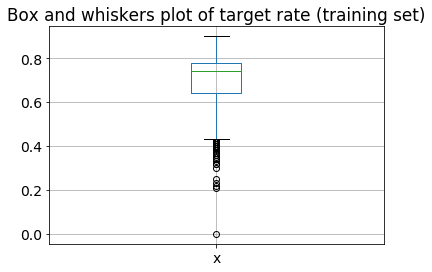

In [23]:
# find outliers via box and whiskers plot (plus the math) in the training data
_, bp = pd.DataFrame.boxplot(comb_train['true'], return_type='both')
plt.title('Box and whiskers plot of target rate (training set)')
outliers = [flier.get_ydata() for flier in bp["fliers"]]
max_out = np.max(outliers)
print('max outlier value is {}'.format(max_out))
plt.savefig('data/imgs/train_target_box_whisker.png')

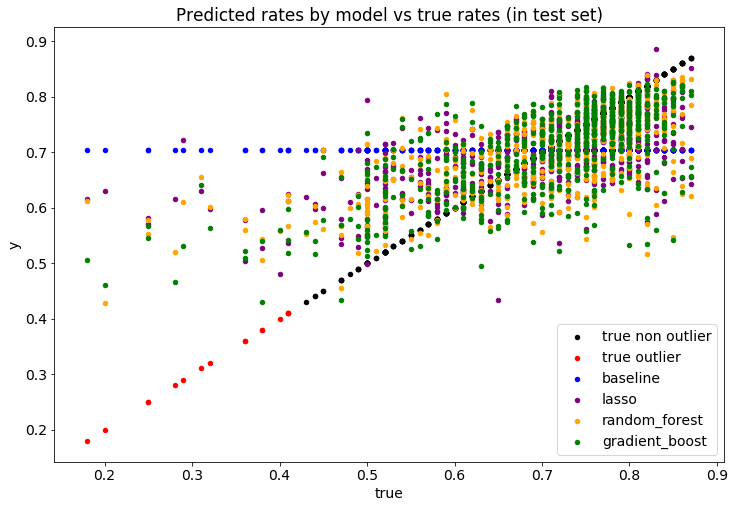

In [24]:
# create two new columns in the test target comparison, splitting out the outlier/non-outlier values per the training box and whiskers plot
y_comp_test['true_non_outlier'] = y_comp_test['true']
y_comp_test['true_outlier'] = y_comp_test['true']
y_comp_test.loc[y_comp_test['true'] <= max_out, 'true_non_outlier'] = np.nan
y_comp_test.loc[y_comp_test['true'] > max_out, 'true_outlier'] = np.nan

# replot the chart from above, separating out the outlier values from y_test
fig, ax = plt.subplots(figsize=(12,8))
y_comp_test.plot(kind='scatter', x='true', y='true_non_outlier', color='black', ax=ax, label='true non outlier')
y_comp_test.plot(kind='scatter', x='true', y='true_outlier', color='red', ax=ax, label='true outlier')

colors = ['b', 'purple', 'orange', 'g']
models = [x for x in list(y_comp_test.columns) if not re.match(r'^true.*', x)]
for i, col in enumerate(models):
    y_comp_test.plot(kind='scatter', x='true', y=models[i], color=colors[i], ax=ax, label=models[i])
ax.set_ylabel('y')
ax.set_title('Predicted rates by model vs true rates (in test set)')
leg = ax.legend();
plt.savefig('data/imgs/test_model_comp_outlier.png')

In [25]:
# look at correlations between low target rates and all of the training variables
comb_train['low_rate_flag'] = comb_train['low_rate'] == 'low (<0.4)'
comb_train['low_rate_flag'] = comb_train['low_rate_flag'].astype(int)
low_rate = comb_train.corr()[['low_rate_flag']]
low_rate['abs_corr'] = abs(low_rate['low_rate_flag'])
low_rate.sort_values('abs_corr', ascending=False, inplace=True)
display(low_rate.head(20))

low_rate_flag  abs_corr
low_rate_flag                                 1.000000  1.000000
gradient_boost                               -0.398388  0.398388
true                                         -0.388696  0.388696
random_forest                                -0.363578  0.363578
total_pop__total_hholds                       0.203098  0.203098
lasso                                        -0.197525  0.197525
total_pop__citizenship_non_citizen            0.170350  0.170350
total_pop__educ_less_than_hs                  0.162729  0.162729
total_hholds__citizenship_non_citizen         0.161426  0.161426
total_hholds__educ_less_than_hs               0.152714  0.152714
total_pop__hhtype_m_householder               0.151781  0.151781
total_pop__income_10k_to_u15k                 0.149175  0.149175
total_pop__incomepovertyratio_1_to_2          0.148619  0.148619
total_hholds__hhtype_m_householder            0.141057  0.141057
total_pop__urbanity_large_central_metro       0.141003  0.141003
total_pop__incomepovertyratio_u1              0.140888  0.140888
total_pop__worktype_non_profit                0.139250  0.139250
total_hholds__income_10k_to_u15k              0.137346  0.137346
total_hholds__incomepovertyratio_1_to_2       0.136878  0.136878
total_pop__marital_never_married              0.136574  0.136574

None of the independent variables are correlated with the low rates so it's unlikely the model will be able to predict those values.  These low rates are outliers and account for about 1% of the data, in training and test, so I'm less concerned that the models don't predict those values.  In the future, I could try additional ACS variables to see if they predict the low rates.

#### Step 7B: Feature Importances

In [26]:
# find the model with the lowest cv rmse
temp = model_comp.sort_values('cv_rmse')
display(temp)
best_model_name = temp.iloc[0, 0]
print('best model is {}'.format(best_model_name))

model_name train_rmse  test_rmse  train_r2   test_r2    cv_rmse  \
3  gradient_boost  0.0476564  0.0822015  0.904735   0.68537  0.0861201   
2   random_forest  0.0297302  0.0843409  0.964044  0.664659  0.0869883   
1           lasso  0.0846324  0.0884045  0.654014  0.621839  0.0909034   
0        baseline   0.111876   0.112931         0       NaN   0.112931   

      cv_r2  
3   0.34992  
2   0.33529  
1  0.271647  
0       NaN

best model is gradient_boost


In [27]:
# determine feature importances for the best model using both the built in feature importances and permutation_importance
start = dt.datetime.now()

best_model = all_models[best_model_name]['model']
best_model.fit(X_train_interact, y_train)

feature_imp = best_model.feature_importances_
feature_imp = pd.DataFrame(feature_imp, columns=['importance'])
feature_imp['variable'] = list(X_train_interact.columns)

result = permutation_importance(best_model, X_train_interact, y_train, random_state=random_seed)
feature_imp['importance_mean'] = result.importances_mean
feature_imp = feature_imp[['variable', 'importance', 'importance_mean']]

feature_imp.sort_values('importance_mean', ascending=False, inplace=True)
feature_imp.to_csv('data/initial_feature_importance.csv')

end = dt.datetime.now()
formatted_time = format_delta(start, end)
print('feature importances generated in {}'.format(formatted_time))

feature_imp.head(30)

feature importances generated in 03:32


variable  importance  \
77                 total_pop__incomepovertyratio_2_plus    0.110083   
43                          structure_year_built_median    0.013484   
1341     structure_year_built_median__urbanity_non_core    0.026297   
65                        total_pop__income_50k_to_u65k    0.015700   
1085          employ_employed__traveltowork_drove_alone    0.045038   
624               income_35k_to_u50k__commutetime_10_30    0.079280   
567           income_25k_to_u35k__livinginarea_20_to_49    0.028140   
168             speak_only_english__livinginarea_1_to_4    0.019427   
1047     incomepovertyratio_2_plus__worktype_government    0.016772   
243              educ_less_than_hs__worktype_non_profit    0.003896   
210               educ_less_than_hs__income_25k_to_u35k    0.007551   
64                        total_pop__income_35k_to_u50k    0.039708   
171           speak_only_english__livinginarea_20_to_49    0.009541   
1036  incomepovertyratio_2_plus__traveltowork_drove_...    0.031437   
194             speak_only_english__worktype_for_profit    0.010311   
127             total_hholds__incomepovertyratio_2_plus    0.005884   
1286                 commutetime_u10__urbanity_non_core    0.012656   
212               educ_less_than_hs__income_50k_to_u65k    0.004538   
833      livinginarea_5_to_17__traveltowork_drove_alone    0.007933   
82                     total_pop__hhtype_married_couple    0.021319   
152                     total_hholds__urbanity_non_core    0.002720   
900            livinginarea_20_to_49__commutetime_10_30    0.004520   
347               educ_college_grad__income_15k_to_u25k    0.008119   
178                 speak_only_english__employ_employed    0.002497   
816              livinginarea_1_to_4__urbanity_non_core    0.004726   
1127        inequality_index_gini__hhtype_m_householder    0.003186   
196             speak_only_english__worktype_government    0.002198   
86                  total_pop__traveltowork_drove_alone    0.008226   
115                    total_hholds__income_50k_to_u65k    0.004131   
1211               hhtype_living_alone__commutetime_u10    0.006725   

      importance_mean  
77           0.041185  
43           0.026352  
1341         0.018846  
65           0.018020  
1085         0.015568  
624          0.014459  
567          0.013993  
168          0.011836  
1047         0.011196  
243          0.011195  
210          0.011094  
64           0.009826  
171          0.007310  
1036         0.006976  
194          0.006757  
127          0.006524  
1286         0.005760  
212          0.005565  
833          0.005519  
82           0.005445  
152          0.005415  
900          0.005361  
347          0.005323  
178          0.004554  
816          0.004536  
1127         0.004420  
196          0.004400  
86           0.004275  
115          0.004250  
1211         0.004139

In [28]:
gb_features = feature_imp.loc[feature_imp['importance'] > 0, 'variable'].values.tolist()
print('{} features used in the gradient boosted model'.format(len(gb_features)))

399 features used in the gradient boosted model


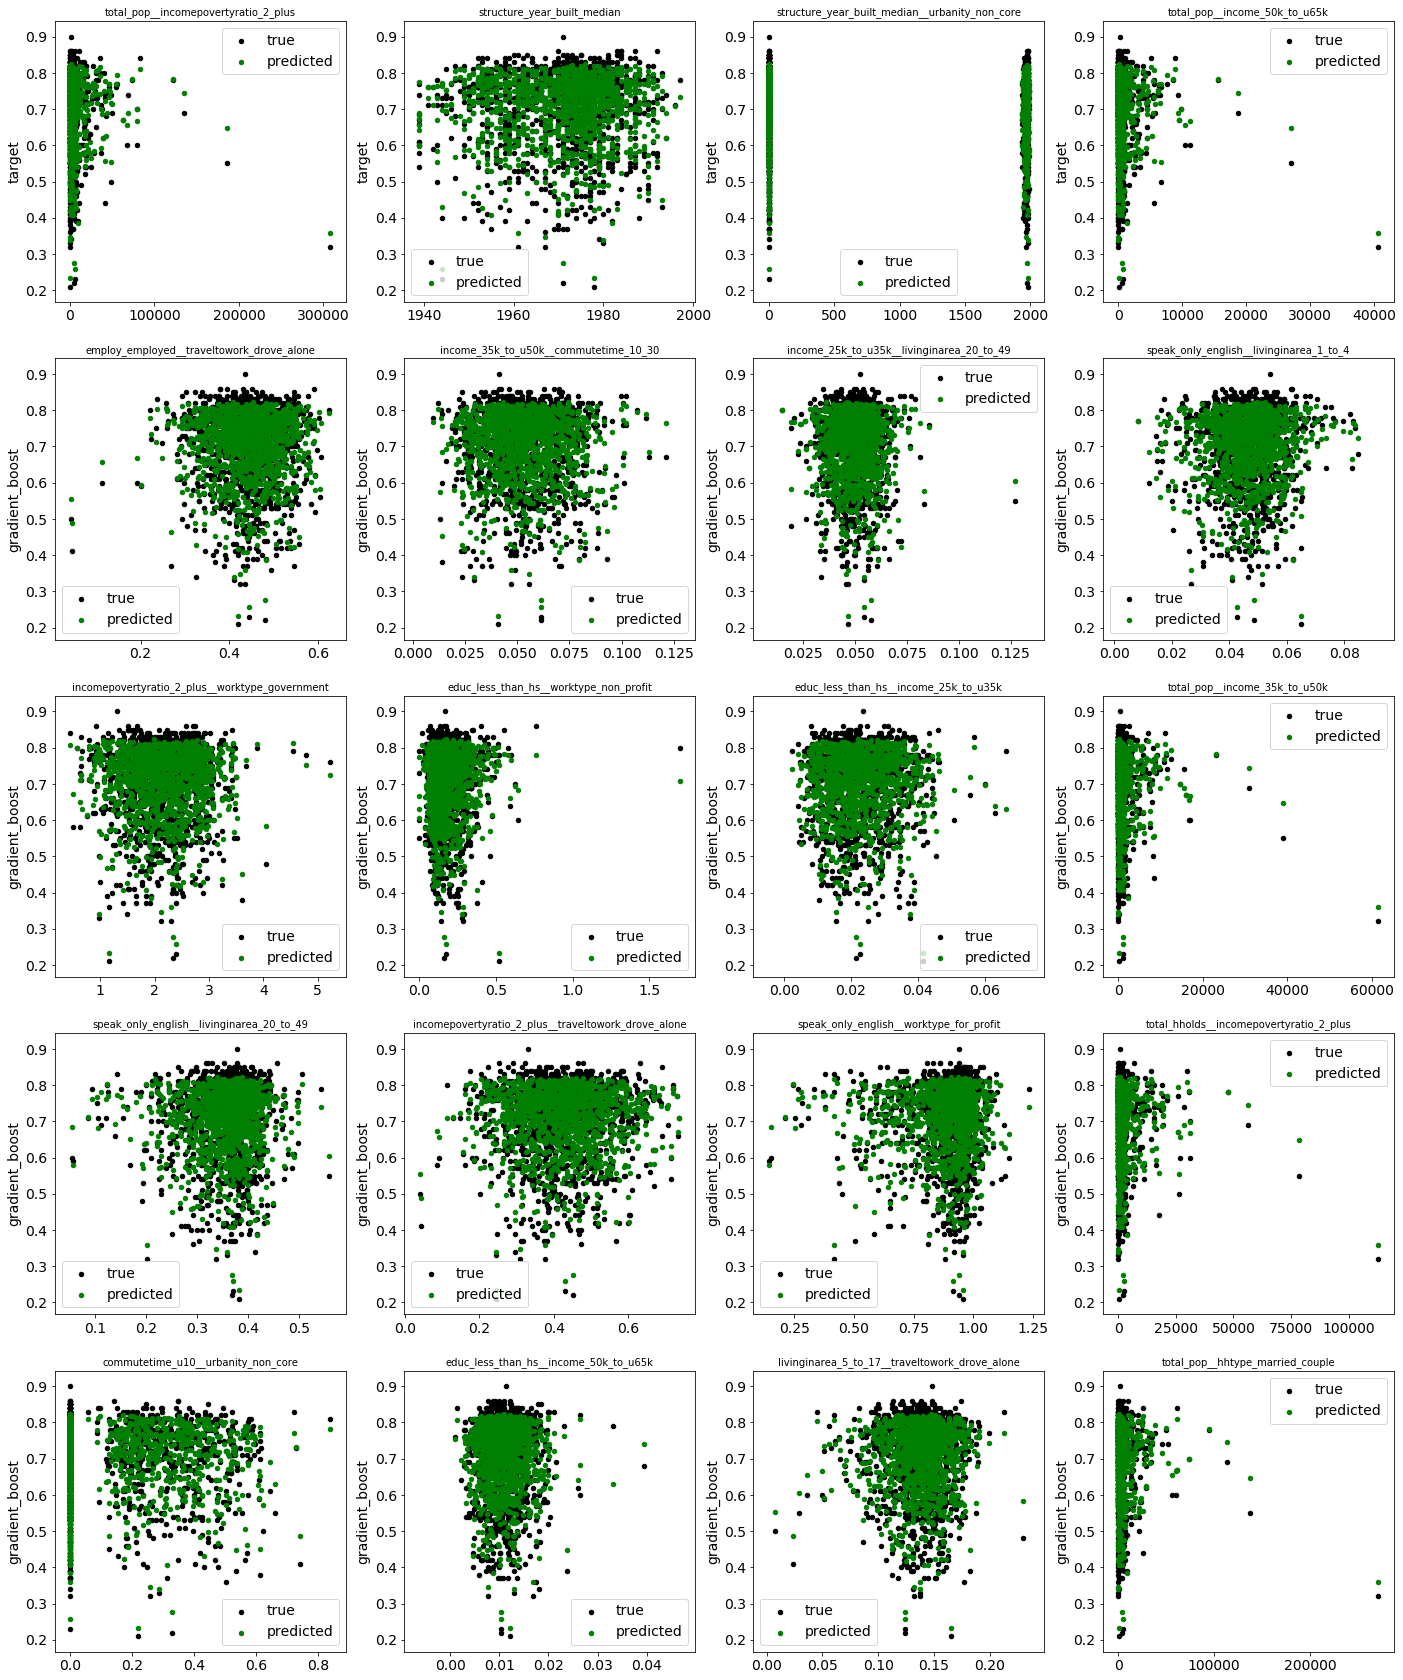

In [29]:
# Here I plot both the actual target variable (y) and the predicted target variable (y hat) against each input (x) in order of feature importance to better understand the relationships.
a, b = 0, 0
fig, ax = plt.subplots(5, 4, figsize=(24, 30))
for i, x in enumerate(gb_features[:20]):
    num_vals = len(comb_train[x].unique())
    if num_vals > 2:
        comb_train.plot(kind='scatter', x=x, y='true', color='black', ax=ax[a, b], label='true')
        comb_train.plot(kind='scatter', x=x, y=best_model_name, color='green', ax=ax[a, b], label='predicted')
        
        ax[a, b].set_title(x)
        if a == 0:
            ax[a, b].set_ylabel('target')
        ax[a, b].set_xlabel('')
        ax[a, b].title.set_fontsize(10)
        leg = ax[a, b].legend()

        if (i + 1) % 4 == 0:
            a += 1
            b = 0
        else:
            b += 1


### Step 8: Feature Tuning
Here I evaluate the gbt model with different sized subsets of the most important features to find the minimum number necessary.  The goal is to reduce over-fitting without sacrificing much of the predictive power.

In [30]:
num_features = list(range(5, 150, 5))
gb_y_comp_train = pd.DataFrame(y_train, columns=['true'])
gb_y_comp_test = pd.DataFrame(y_test, columns=['true'])
gb_train_rmse = []
gb_train_r2 = []
gb_test_rmse = []
gb_test_r2 = []
gb_cv_rmse = []

X_interact = poly.fit_transform(X)
new_cols = interaction_columns(list(X.columns))
X_interact = pd.DataFrame(X_interact, columns=new_cols)

gbt = GradientBoostingRegressor(random_state=random_seed)

total_start = dt.datetime.now()
for n in num_features:
    start = dt.datetime.now()
    
    # subset features
    cur_features = gb_features[:n]
    temp_x_train = X_train_interact[cur_features].copy()
    temp_x_test = X_test_interact[cur_features].copy()

    # fit and predict
    gbt.fit(temp_x_train, y_train)
    yhat_train = gbt.predict(temp_x_train)
    yhat_test = gbt.predict(temp_x_test)

    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, yhat_train))
    test_rmse = np.sqrt(metrics.mean_squared_error(y_test, yhat_test))

    train_r2 = np.sqrt(metrics.r2_score(y_train, yhat_train))
    test_r2 = np.sqrt(metrics.r2_score(y_test, yhat_test))

    # cross validation
    temp_x = X_interact[cur_features].copy()
    cv_results = cross_validate(m['model'], temp_x, y, cv=5, scoring=['neg_mean_squared_error', 'r2'])
    cv_rmse = np.sqrt(np.mean(-1 * cv_results['test_neg_mean_squared_error']))

    # store values
    model_name = 'n_{}'.format(n)
    gb_y_comp_train[model_name] = yhat_train
    gb_y_comp_test[model_name] = yhat_test
    gb_train_rmse.append(train_rmse)
    gb_train_r2.append(train_r2)
    gb_test_rmse.append(test_rmse)
    gb_test_r2.append(test_r2)
    gb_cv_rmse.append(cv_rmse)

    end = dt.datetime.now()
    formatted_time = format_delta(start, end)
    print('{} evaluated in {}'.format(model_name, formatted_time))

total_end = dt.datetime.now()
formatted_time = format_delta(total_start, total_end)
print('all evaluated in {}'.format(formatted_time))    


n_5 evaluated in 00:01
n_10 evaluated in 00:02
n_15 evaluated in 00:03
n_20 evaluated in 00:04
n_25 evaluated in 00:05
n_30 evaluated in 00:06
n_35 evaluated in 00:08
n_40 evaluated in 00:09
n_45 evaluated in 00:10
n_50 evaluated in 00:11
n_55 evaluated in 00:12
n_60 evaluated in 00:13
n_65 evaluated in 00:14
n_70 evaluated in 00:15
n_75 evaluated in 00:16
n_80 evaluated in 00:17
n_85 evaluated in 00:18
n_90 evaluated in 00:19
n_95 evaluated in 00:20
n_100 evaluated in 00:22
n_105 evaluated in 00:23
n_110 evaluated in 00:24
n_115 evaluated in 00:25
n_120 evaluated in 00:26
n_125 evaluated in 00:27
n_130 evaluated in 00:29
n_135 evaluated in 00:30
n_140 evaluated in 00:31
n_145 evaluated in 00:32
all evaluated in 08:04


num  train_rmse  test_rmse   cv_rmse
9    50    0.052022   0.080836  0.081730
7    40    0.053685   0.081823  0.081812
14   75    0.050512   0.081509  0.082257
8    45    0.052526   0.080507  0.082420
13   70    0.051488   0.080850  0.082520

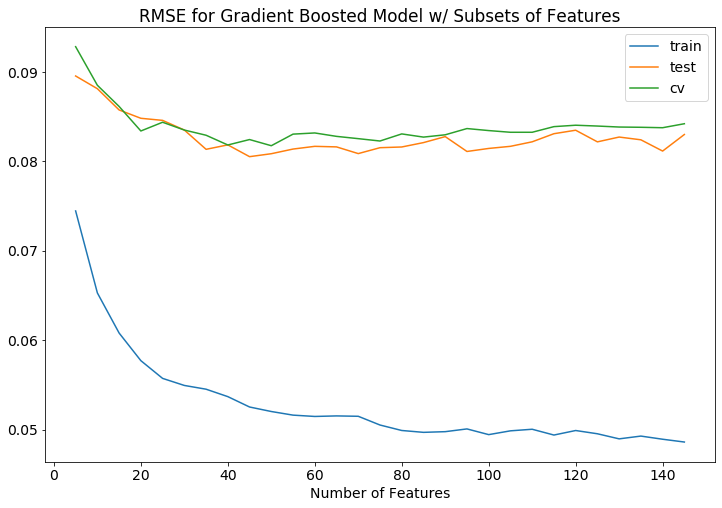

In [31]:
gb_stats = pd.DataFrame(num_features, columns=['num'])
gb_stats['train_rmse'] = gb_train_rmse
gb_stats['test_rmse'] = gb_test_rmse
gb_stats['cv_rmse'] = gb_cv_rmse

fig, ax = plt.subplots(figsize=(12,8))
gb_stats.plot(kind='line', x='num', y='train_rmse', ax=ax, label='train')
gb_stats.plot(kind='line', x='num', y='test_rmse', ax=ax, label='test')
gb_stats.plot(kind='line', x='num', y='cv_rmse', ax=ax, label='cv')

ax.set_title('RMSE for Gradient Boosted Model w/ Subsets of Features')
ax.set_ylabel('')
ax.set_xlabel('Number of Features')
leg = ax.legend();
plt.savefig('data/imgs/gb_feature_tuning.png')

gb_stats.sort_values('cv_rmse', inplace=True)
display(gb_stats.head())

### Step 9: Save Final Versions

In [32]:
# create function to prep data for scoring
def prep_for_scoring(df, transformer, features, y_var='rate_2010'):
    ''' prep dataframe for scoring

    :param df: pandas dataframe with same columns as initial combined data
    :param transformer: fit transformer to apply
    :param features: list of features to retain after transformation
    :param y_var: str variable name for y/target
        (default: rate_2010)

    :return: transformed dataframe, y series
    '''

    df = df.select_dtypes(exclude=['object'])
    if y_var in df.columns:
        y = df[y_var].copy()
        df.drop(y_var, axis=1, inplace=True)
    else:
        y = None
    new = transformer.fit_transform(df)
    cols = interaction_columns(list(df.columns))
    new = pd.DataFrame(new, columns=cols)
    new = new[features].copy()
    return new, y


In [33]:
temp = poly.fit(X_train)
pickle.dump(poly, open('data/objects/transformer.pkl', 'wb'))

X_train_final, _ = prep_for_scoring(X_train, poly, gb_features[:50])
X_train_final.to_pickle('data/objects/x_train.pkl')
y_train.to_pickle('data/objects/y_train.pkl')

gbt = GradientBoostingRegressor(random_state=random_seed)
gbt.fit(X_train_final, y_train)
pickle.dump(gbt, open('data/objects/model.pkl', 'wb'))

pickle.dump(prep_for_scoring, open('data/objects/prep_func.pkl', 'wb'))

### Step 10: Evaluate on Holdout Set

In [34]:
# reload objects from pickles
holdout = pd.read_pickle('data/objects/holdout.pkl')
model = pickle.load(open('data/objects/model.pkl', 'rb'))
transformer = pickle.load(open('data/objects/transformer.pkl', 'rb'))
training = pd.read_pickle('data/objects/x_train.pkl')
train_y = pd.read_pickle('data/objects/y_train.pkl')
prep_func = pickle.load(open('data/objects/prep_func.pkl', 'rb'))

input_data, target = prep_func(holdout, transformer, list(training.columns))
y_hat = model.predict(input_data)

In [35]:
rmse = np.sqrt(metrics.mean_squared_error(target, y_hat))
r2 = np.sqrt(metrics.r2_score(target, y_hat))

print('holdout rmse is {}'.format(round(rmse, 4)))
print('r2 is {}'.format(round(r2, 4)))

holdout rmse is 0.0817
r2 is 0.7033


In [36]:
chart = pd.DataFrame()
chart['true'] = target
chart['predicted'] = y_hat
chart['true_dec'] = round(chart['true'], 1)

deciles = chart['true_dec'].value_counts(normalize=True).reset_index().rename({'true_dec': 'true_pct', 'index': 'true_dec'}, axis='columns')
chart = pd.merge(chart, deciles, how='left')
chart['true_pct'] = round(round(chart['true_pct'], 2) * 50) ** 2

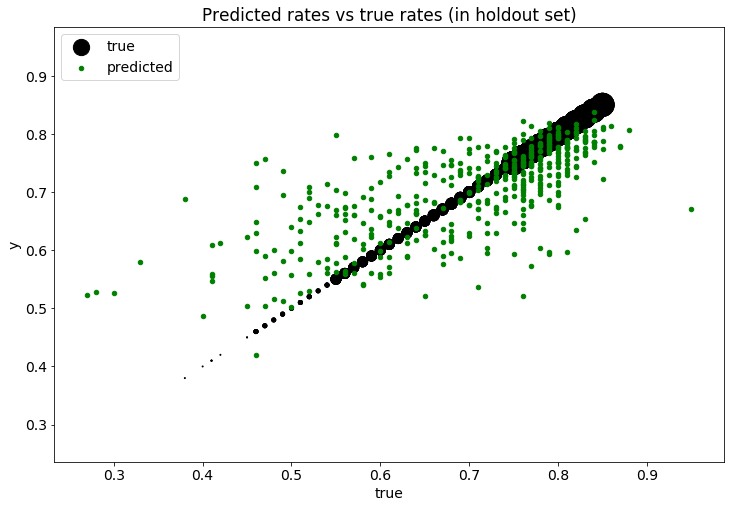

In [37]:
fig, ax = plt.subplots(figsize=(12,8))
chart.plot(kind='scatter', x='true', y='true', color='black', ax=ax, label='true', s=chart['true_pct'])
chart.plot(kind='scatter', x='true', y='predicted', color='green', ax=ax, label='predicted')
ax.set_ylabel('y')
ax.set_title('Predicted rates vs true rates (in holdout set)')
leg = ax.legend();
plt.savefig('data/imgs/holdout_model_comp.png')